In [ ]:
try:
    import openmdao.api as om
    import dymos as dm
except ImportError:
    !python -m pip install openmdao[notebooks]
    !python -m pip install dymos
    import openmdao.api as om
    import dymos as dm

# The Van der Pol Oscillator

In dynamics, the Van Der Pol oscillator {cite}`wikivanderpol` is a non-conservative oscillator with non-linear damping. It evolves in time according to the second-order differential equation:

\begin{align}
    \frac{d^2x}{dt^2} - u (1 - x^2) \frac{dx}{dt} + x &= 0
\end{align}

where $x$ is the position coordinate (a function of the time $t$), and $u$ is a scalar parameter
indicating the nonlinearity and the strength of the damping.

To make this an optimal control problem, we want to find the smallest control that will dampen the oscillation
(drive the state variables to zero). We can express this as an objective function $J$ to minimize:

\begin{align}
    J &= \int x^2_0 + x^2_1 + u^2
\end{align}

In other words, we want to find the optimal (smallest) trajectory of the control $u$ such that the oscillation
and the oscillation's rate of change are driven to zero.

## State Variables

There are three _state_ variables are used to define the configuration of the system at any given instant in time.

-   $x_1$: The primary output of the oscillator.
-   $x_0$: The rate of change of the primary output.
-   $J$: The objective function to be minimized.

The objective function is included as a state variable so that Dymos will do the integration.

The $x_1$ and $x_0$ state variables are also inputs to the system, along with the control $u$.

## System Dynamics

The evolution of the state variables is given by the following ordinary differential equations (ODE):

\begin{align}
    \frac{dx_0}{dt} &= (1 - x^2_1) x_0 - x_1 + u \\
    \frac{dx_1}{dt} &= x_0 \\
    \frac{dJ}{dt} &= x^2_0 + x^2_1 + u^2
\end{align}

## Control Variables

This system has a single control variable:

-   $u$: The control input.

The control variable has a constraint: $-0.75 \leq u \leq 1.0$

## The initial and final conditions

The initial conditions are:

\begin{align}
    x_0 &= 1 \\
    x_1 &= 1 \\
      u &= -0.75
\end{align}

The final conditions are:

\begin{align}
    x_0 &= 0 \\
    x_1 &= 0 \\
      u &= 0
\end{align}

## Defining the ODE as an OpenMDAO System

In Dymos, the ODE is an OpenMDAO System (a Component, or a Group of components).
The following _ExplicitComponent_ computes the state rates for the Van der Pol problem.

More detail on the workings of an _ExplicitComponent_ can be found in the OpenMDAO documentation.  In summary:

-   **initialize**:  Called at setup, and used to define options for the component.  **ALL** Dymos ODE components
    should have the property `num_nodes`, which defines the number of points at which the outputs are simultaneously computed.
-   **setup**: Used to add inputs and outputs to the component, and declare which outputs (and indices of outputs)
    are dependent on each of the inputs.
-   **compute**: Used to compute the outputs, given the inputs.
-   **compute_partials**: Used to compute the derivatives of the outputs with respect to each of the inputs analytically.
    This method may be omitted if finite difference or complex-step approximations are used, though analytic is recommended.

```{Note} Things to note about the Van der Pol ODE system
- Only the _vanderpol_ode_ class below is important for defining the basic problem. The other classes are
  used to demonstrate Message Passing Interface (MPI) parallel calculation of the system. They can be ignored.
- $x_1$, $x_0$, and $u$ are inputs.
- $\dot{x_1}$, $\dot{x_0}$, and $\dot{J}$ are outputs.
- **declare_partials** is called for every output with respect to every input.
- For efficiency, partial derrivatives that are constant have values specified in the **setup** method rather than
  the **compute_partials** method. So although 9 partials are declared, only 5 are computed in **compute_partials**.
```

In [8]:
import numpy as np
import openmdao.api as om
import time
from openmdao.utils.array_utils import evenly_distrib_idxs


class VanderpolODE(om.ExplicitComponent):
    """intentionally slow version of vanderpol_ode for effects of demonstrating distributed component calculations

    MPI can run this component in multiple processes, distributing the calculation of derivatives.
    This code has a delay in it to simulate a longer computation. It should run faster with more processes.
    """

    def __init__(self, *args, **kwargs):
        self.progress_prints = False
        super().__init__(*args, **kwargs)

    def initialize(self):
        self.options.declare('num_nodes', types=int)
        self.options.declare('distrib', types=bool, default=False)
        self.options.declare('delay', types=(float,), default=0.0)

    def setup(self):
        nn = self.options['num_nodes']
        comm = self.comm
        rank = comm.rank

        sizes, offsets = evenly_distrib_idxs(comm.size, nn)  # (#cpus, #inputs) -> (size array, offset array)
        self.start_idx = offsets[rank]
        self.io_size = sizes[rank]  # number of inputs and outputs managed by this distributed process
        self.end_idx = self.start_idx + self.io_size

        # inputs: 2 states and a control
        self.add_input('x0', val=np.ones(nn), desc='derivative of Output', units='V/s')
        self.add_input('x1', val=np.ones(nn), desc='Output', units='V')
        self.add_input('u', val=np.ones(nn), desc='control', units=None)

        # outputs: derivative of states
        # the objective function will be treated as a state for computation, so its derivative is an output
        self.add_output('x0dot', val=np.ones(self.io_size), desc='second derivative of Output',
                        units='V/s**2', distributed=self.options['distrib'])
        self.add_output('x1dot', val=np.ones(self.io_size), desc='derivative of Output',
                        units='V/s', distributed=self.options['distrib'])
        self.add_output('Jdot', val=np.ones(self.io_size), desc='derivative of objective',
                        units='1.0/s', distributed=self.options['distrib'])

        # self.declare_coloring(method='cs')
        # # partials
        r = np.arange(self.io_size, dtype=int)
        c = r + self.start_idx

        self.declare_partials(of='x0dot', wrt='x0',  rows=r, cols=c)
        self.declare_partials(of='x0dot', wrt='x1',  rows=r, cols=c)
        self.declare_partials(of='x0dot', wrt='u',   rows=r, cols=c, val=1.0)

        self.declare_partials(of='x1dot', wrt='x0',  rows=r, cols=c, val=1.0)

        self.declare_partials(of='Jdot', wrt='x0',  rows=r, cols=c)
        self.declare_partials(of='Jdot', wrt='x1',  rows=r, cols=c)
        self.declare_partials(of='Jdot', wrt='u',   rows=r, cols=c)

    def compute(self, inputs, outputs):
        # introduce slowness proportional to size of computation
        time.sleep(self.options['delay'] * self.io_size)

        # The inputs contain the entire vector, be each rank will only operate on a portion of it.
        x0 = inputs['x0'][self.start_idx:self.end_idx]
        x1 = inputs['x1'][self.start_idx:self.end_idx]
        u = inputs['u'][self.start_idx:self.end_idx]

        outputs['x0dot'] = (1.0 - x1**2) * x0 - x1 + u
        outputs['x1dot'] = x0
        outputs['Jdot'] = x0**2 + x1**2 + u**2

    def compute_partials(self, inputs, jacobian):
        time.sleep(self.options['delay'] * self.io_size)

        x0 = inputs['x0'][self.start_idx:self.end_idx]
        x1 = inputs['x1'][self.start_idx:self.end_idx]
        u = inputs['u'][self.start_idx:self.end_idx]

        jacobian['x0dot', 'x0'] = 1.0 - x1 * x1
        jacobian['x0dot', 'x1'] = -2.0 * x1 * x0 - 1.0

        jacobian['Jdot', 'x0'] = 2.0 * x0
        jacobian['Jdot', 'x1'] = 2.0 * x1
        jacobian['Jdot', 'u'] = 2.0 * u

## Defining the Dymos Problem

Once the ODEs are defined, they are used to create a Dymos _Problem_ object that allows solution.

```{Note} Things to note about the Van der Pol Dymos Problem definition
- The **vanderpol** function creates and returns a Dymos _Problem_ instance that can be used
  for simulation or optimization.
- The **vanderpol** function has optional arguments for specifying options for the
  type of transcription, number of segments, optimizer, etc. These can be ignored
  when first trying to understand the code.
- The _Problem_ object has a _Trajectory_ object, and the trajectory has a single _Phase_.
  Most of the problem setup is performed by calling methods on the phase (**set_time_options**,
  **add_state**, **add_boundary_constraint**, **add_objective**).
- The **add_state** and **add_control** calls include the _target_ parameter for $x_0$, $x_1$, and $u$.
  This is required so that the inputs are correctly calculated.
- Initial (linear) guesses are supplied for the states and control.
```

In [9]:
import openmdao.api as om
import dymos as dm

def vanderpol(transcription='gauss-lobatto', num_segments=40, transcription_order=3,
              compressed=True, optimizer='SLSQP', use_pyoptsparse=False, delay=0.0, distrib=True,
              solve_segments=False):
    """Dymos problem definition for optimal control of a Van der Pol oscillator"""

    # define the OpenMDAO problem
    p = om.Problem(model=om.Group())

    if not use_pyoptsparse:
        p.driver = om.ScipyOptimizeDriver()
    else:
        p.driver = om.pyOptSparseDriver()
    p.driver.options['optimizer'] = optimizer
    if use_pyoptsparse:
        if optimizer == 'SNOPT':
            p.driver.opt_settings['iSumm'] = 6  # show detailed SNOPT output
        elif optimizer == 'IPOPT':
            p.driver.opt_settings['print_level'] = 4
    p.driver.declare_coloring()

    # define a Trajectory object and add to model
    traj = dm.Trajectory()
    p.model.add_subsystem('traj', subsys=traj)

    # define a Transcription
    if transcription == 'gauss-lobatto':
        t = dm.GaussLobatto(num_segments=num_segments,
                            order=transcription_order,
                            compressed=compressed,
                            solve_segments=solve_segments)
    elif transcription == 'radau-ps':
        t = dm.Radau(num_segments=num_segments,
                     order=transcription_order,
                     compressed=compressed,
                     solve_segments=solve_segments)

    # define a Phase as specified above and add to Phase
    phase = dm.Phase(ode_class=VanderpolODE, transcription=t,
                     ode_init_kwargs={'delay': delay, 'distrib': distrib})
    traj.add_phase(name='phase0', phase=phase)

    t_final = 15
    phase.set_time_options(fix_initial=True, fix_duration=True, duration_val=t_final, units='s')

    # set the State time options
    phase.add_state('x0', fix_initial=False, fix_final=False,
                    rate_source='x0dot',
                    units='V/s',
                    targets='x0')  # target required because x0 is an input
    phase.add_state('x1', fix_initial=False, fix_final=False,
                    rate_source='x1dot',
                    units='V',
                    targets='x1')  # target required because x1 is an input
    phase.add_state('J', fix_initial=False, fix_final=False,
                    rate_source='Jdot',
                    units=None)

    # define the control
    phase.add_control(name='u', units=None, lower=-0.75, upper=1.0, continuity=True,
                      rate_continuity=True, targets='u')  # target required because u is an input

    # add constraints
    phase.add_boundary_constraint('x0', loc='initial', equals=1.0)
    phase.add_boundary_constraint('x1', loc='initial', equals=1.0)
    phase.add_boundary_constraint('J', loc='initial', equals=0.0)

    phase.add_boundary_constraint('x0', loc='final', equals=0.0)
    phase.add_boundary_constraint('x1', loc='final', equals=0.0)

    # define objective to minimize
    phase.add_objective('J', loc='final')

    # setup the problem
    p.setup(check=True)

    p['traj.phase0.t_initial'] = 0.0
    p['traj.phase0.t_duration'] = t_final

    # add a linearly interpolated initial guess for the state and control curves
    p['traj.phase0.states:x0'] = phase.interp('x0', [1, 0])
    p['traj.phase0.states:x1'] = phase.interp('x1', [1, 0])
    p['traj.phase0.states:J'] = phase.interp('J', [0, 1])
    p['traj.phase0.controls:u'] = phase.interp('u', [-0.75, -0.75])

    return p


if __name__ == '__main__':
    # just set up the problem, test it elsewhere
    p = vanderpol(transcription='radau-ps', num_segments=30, transcription_order=3,
                  compressed=True, optimizer='SLSQP', delay=0.005, distrib=True, use_pyoptsparse=True)

    dm.run_problem(p, run_driver=True, simulate=False)

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
Full total jacobian was computed 3 times, taking 2.297734 seconds.
Total jacobian shape: (329, 363) 


Jacobian shape: (329, 363)  ( 1.97% nonzero)
FWD solves: 13   REV solves: 0
Total colors vs. total size: 13 vs 363  (96.4% improvement)

Sparsity computed using tolerance: 1e-25
Time to compute sparsity: 2.297734 sec.
Time to compute coloring: 0.288472 sec.
Memory to compute coloring: -2.359375 MB.


Optimization Problem -- Optimization using pyOpt_sparse
    Objective Function: _objfunc

    Solution: 
--------------------------------------------------------------------------------
    Total

## Simulating the Problem (without control)

The following script creates an instance of the Dymos vanderpol problem and simulates it.

Since the problem was only simulated and not solved, the solution lines in the plots show only
the initial guesses for $x_0$, $x_1$, and $u$. The simulation lines shown in the plots are the
system response with the control variable $u$ held constant.

The first two plots shows the variables $x_0$ and $x_1$ vs time. The third plots shows $x_0$ vs. $x_1$
(which will be mostly circular in the case of undamped oscillation). The final plot is the (fixed)
control variable $u$ vs time.

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings

Simulating trajectory traj
Done simulating trajectory traj


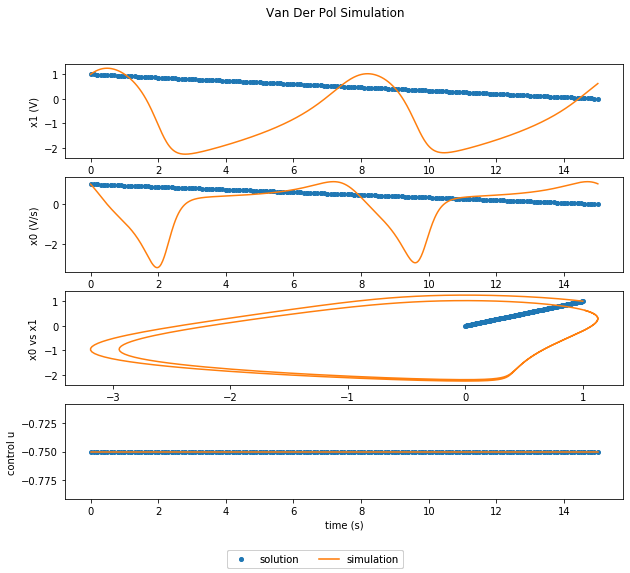

In [11]:
from dymos.examples.plotting import plot_results
from dymos.examples.vanderpol.vanderpol_dymos import vanderpol
import matplotlib.pyplot as plt

# Create the Dymos problem instance
p = vanderpol(transcription='gauss-lobatto', num_segments=75)

# Run the problem (simulate only)
p.run_model()

# check validity by using scipy.integrate.solve_ivp to integrate the solution
exp_out = p.model.traj.simulate()

# Display the results
plot_results([('traj.phase0.timeseries.time',
               'traj.phase0.timeseries.states:x1',
               'time (s)',
               'x1 (V)'),
             ('traj.phase0.timeseries.time',
              'traj.phase0.timeseries.states:x0',
              'time (s)',
              'x0 (V/s)'),
              ('traj.phase0.timeseries.states:x0',
               'traj.phase0.timeseries.states:x1',
               'x0 vs x1',
               'x0 vs x1'),
             ('traj.phase0.timeseries.time',
              'traj.phase0.timeseries.controls:u',
              'time (s)',
              'control u'),
              ],
             title='Van Der Pol Simulation',
             p_sol=p, p_sim=exp_out)

plt.show()

## Solving the Optimal Control Problem

The next example shows optimization followed by simulation.

With a successful optimization, the resulting plots show a good match between the simulated (with varying control)
and optimized results. The state variables $x_0$ and $x_1$ as well as the control variable $u$ are all driven to zero.

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
Full total jacobian was computed 3 times, taking 1.521301 seconds.
Total jacobian shape: (300, 379) 


Jacobian shape: (300, 379)  ( 1.84% nonzero)
FWD solves: 9   REV solves: 0
Total colors vs. total size: 9 vs 379  (97.6% improvement)

Sparsity computed using tolerance: 1e-25
Time to compute sparsity: 1.521301 sec.
Time to compute coloring: 0.246434 sec.
Memory to compute coloring: -0.039062 MB.

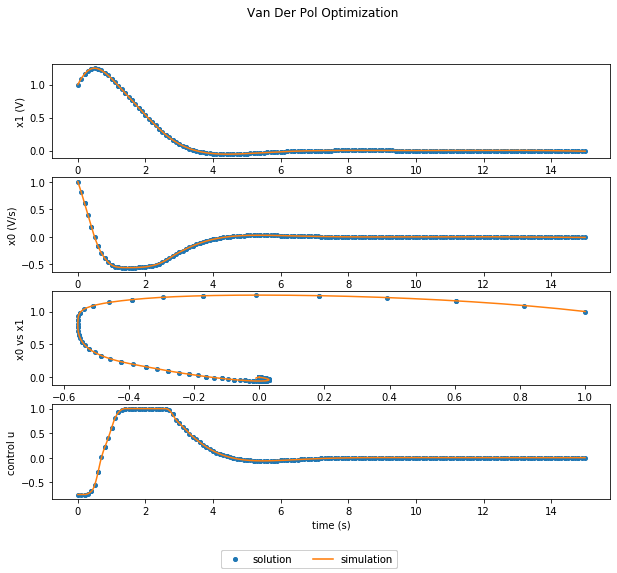

In [12]:
import dymos as dm
from dymos.examples.plotting import plot_results
from dymos.examples.vanderpol.vanderpol_dymos import vanderpol

# Create the Dymos problem instance
p = vanderpol(transcription='gauss-lobatto', num_segments=75,
              transcription_order=3, compressed=True, optimizer='SLSQP')

# Find optimal control solution to stop oscillation
dm.run_problem(p)

# check validity by using scipy.integrate.solve_ivp to integrate the solution
exp_out = p.model.traj.simulate()

# Display the results
plot_results([('traj.phase0.timeseries.time',
               'traj.phase0.timeseries.states:x1',
               'time (s)',
               'x1 (V)'),
             ('traj.phase0.timeseries.time',
              'traj.phase0.timeseries.states:x0',
              'time (s)',
              'x0 (V/s)'),
              ('traj.phase0.timeseries.states:x0',
               'traj.phase0.timeseries.states:x1',
               'x0 vs x1',
               'x0 vs x1'),
             ('traj.phase0.timeseries.time',
              'traj.phase0.timeseries.controls:u',
              'time (s)',
              'control u'),
              ],
             title='Van Der Pol Optimization',
             p_sol=p, p_sim=exp_out)

plt.show()

## Solving the Optimal Control Problem with Grid Refinement

Repeating the optimization with grid refinement enabled requires changing only two lines in the code. For the sake
of grid refinement demonstration, the initial number of segments is also reduced by a factor of 5.

Optimization with grid refinement gets results similar to the example without grid refinement, but runs faster
and does not require supplying a good guess for the number segments.

In [ ]:
import dymos as dm
from dymos.examples.plotting import plot_results
from dymos.examples.vanderpol.vanderpol_dymos import vanderpol

# Create the Dymos problem instance
p = vanderpol(transcription='gauss-lobatto', num_segments=15,
              transcription_order=3, compressed=True, optimizer='SLSQP')

# Enable grid refinement and find optimal control solution to stop oscillation
p.model.traj.phases.phase0.set_refine_options(refine=True)
dm.run_problem(p, refine_iteration_limit=10)

# check validity by using scipy.integrate.solve_ivp to integrate the solution
exp_out = p.model.traj.simulate()

# Display the results
plot_results([('traj.phase0.timeseries.time',
               'traj.phase0.timeseries.states:x1',
               'time (s)',
               'x1 (V)'),
             ('traj.phase0.timeseries.time',
              'traj.phase0.timeseries.states:x0',
              'time (s)',
              'x0 (V/s)'),
              ('traj.phase0.timeseries.states:x0',
               'traj.phase0.timeseries.states:x1',
               'x0 vs x1',
               'x0 vs x1'),
             ('traj.phase0.timeseries.time',
              'traj.phase0.timeseries.controls:u',
              'time (s)',
              'control u'),
              ],
             title='Van Der Pol Optimization with Grid Refinement',
             p_sol=p, p_sim=exp_out)

plt.show()

## References

```{bibliography}
:filter: docname in docnames
```